#### 사용자 행동 인식

In [1]:
# 피처의 명칭 확인
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# 피처 이름과 피처명이 공백으로 분리 => DF로 로드
feature_name_df = pd.read_csv('../data/UCI_HAR_Dataset/features.txt',sep='\s+', header=None, names=['column_index','column_name'])

In [3]:
# 피처명 index 제거, 피처명만 리스트 객체로 생성한 뒤 샘플로 10개만 추출
feature_name = feature_name_df.iloc[:,1].values.tolist()
print(f'전체 피처명에서 10개만 추출 : {feature_name[:10]}')

전체 피처명에서 10개만 추출 : ['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z', 'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z', 'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z', 'tBodyAcc-max()-X']


In [4]:
# 파일내에 중복된 피처명을 가지고 있음 => 원본 피처명에 _1, _2 추가로 부여애 변경
# 중복된 데이터 확인
feature_dup_df = feature_name_df.groupby('column_name').count()
print(feature_dup_df[feature_dup_df['column_index']>1].count())
feature_dup_df[feature_dup_df['column_index']>1].head()
# 총 42개의 피처명이 중복 => 중복 값에 _1 또는 _2를 추가 부여

column_index    42
dtype: int64


,column_index
column_name,
"fBodyAcc-bandsEnergy()-1,16",3
"fBodyAcc-bandsEnergy()-1,24",3
"fBodyAcc-bandsEnergy()-1,8",3
"fBodyAcc-bandsEnergy()-17,24",3
"fBodyAcc-bandsEnergy()-17,32",3


In [7]:
# 함수 설정
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(), columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name','dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) if x[1]>0 else x[0], axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

In [8]:
# 학습용 피처 데이터세트, 레이블 데이터세트, 테스트용 피처 데이터 파일, 레이블 데이터 파일 각각 학습/테스트용 DataFrame에 로드
# 공백으로 분리되어 있어 sep인자로 공백문자 입력
def get_human_dataset():
    # 각 데이터파일 분리 : 공백 => read_csv 에서 공백 문자를 sep로 할당
    feature_name_df = pd.read_csv('../data/uci_har_Dataset/features.txt', sep='\s+', header= None, names=['column_index', 'column_name'])
    # 중복되는 피처명 수정을 위해 get_new_feature_name_df()이용 => 신규 피처명 DataFrame생성
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    # DataFrame에 피처명을 칼럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:,1].values.tolist()

    # 학습 피처 데이터 세트와 테스트 데이터를 DF로 로딩, 칼럼명은 feature_name으로 적용
    X_train = pd.read_csv('../data/uci_har_dataset/train/X_train.txt', sep='\s+', names= feature_name)
    X_test = pd.read_csv('../data/uci_har_dataset/test/X_test.txt', sep='\s+', names= feature_name)
    # 학습 레이블과 테스트 레이블 데이터를 DF로 로딩하고 칼럼명을 action으로 부여
    y_train = pd.read_csv('../data/uci_har_dataset/train/y_train.txt', sep='\s+',header=None, names= ['action'])
    y_test = pd.read_csv('../data/uci_har_dataset/test/y_test.txt', sep='\s+',header=None, names= ['action'])

    # 로드된 학습/테스트용 DF를 모두 반환
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_human_dataset()

In [9]:
# 학습용 피처 데이터 세트 확인 => 7352개 레코드, 561개 피처 / 데이터 타입 모두 float => 인코딩 불필요
print('## 학습 피처 데이터셋 info()')
print(X_train.info())

## 학습 피처 데이터셋 info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, tBodyAcc-mean()-X to angle(Z,gravityMean)
dtypes: float64(561)
memory usage: 31.5 MB
None


In [10]:
# 레이블 값 분포 확인 => 특정 값으로 왜곡되지 않고 비교적 고르게 값 분포
print(y_train['action'].value_counts())

action
6    1407
5    1374
4    1286
1    1226
2    1073
3     986
Name: count, dtype: int64


In [11]:
# DecisionTreeClassifier를 이용해 동작 예측 분류 수행
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# 예제 반복시마다 동일한 예측 결과 도출을 위해 random_state 설정
dt_clf = DecisionTreeClassifier(random_state=156)
dt_clf.fit(X_train, y_train)
pred = dt_clf.predict(X_test)
accuracy = accuracy_score(y_test,pred)
print(f'결정 트리 예측 정확도 : {accuracy:.4f}')

결정 트리 예측 정확도 : 0.8548


In [12]:
# DecisionTreeClassifier의 하이퍼파라미터 추출
print('DecisionTreeClassifier 기본 하이퍼 파라미터 :\n', dt_clf.get_params())

DecisionTreeClassifier 기본 하이퍼 파라미터 :
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 156, 'splitter': 'best'}


In [17]:
# GridSearchCV를 사용해 하이퍼파라미터 변화
from sklearn.model_selection import GridSearchCV
params = {'max_depth' : [6,8,10,12,16,20,24], 'min_samples_split':[16]}
grid_cv =  GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=5, verbose=1)
grid_cv.fit(X_train,y_train)
print(f'GridSearchCV 최고 평균 정확도 수치 : {grid_cv.best_score_:.4f}')
print(f'GridSearchCV 최적 하이퍼 파라미터 : {grid_cv.best_params_}')

Fitting 5 folds for each of 7 candidates, totalling 35 fits
GridSearchCV 최고 평균 정확도 수치 : 0.8549
GridSearchCV 최적 하이퍼 파라미터 : {'max_depth': 8, 'min_samples_split': 16}


In [18]:
# max_depth에 따른 평가 데이터세트의 평균 정확도 수치 => cv_results_에서 추출해 DF로 생성
cv_results_df = pd.DataFrame(grid_cv.cv_results_)

# max_depth의 하이퍼파라미터 값 + 그때의 테스트세트, 학습 데이터 세트의 정확도 수치 추출
cv_results_df[['param_max_depth', 'mean_test_score']]

# mean_test_score : 5개 CV세트에서 검중용 테이터 세트의 정확도 평균 수치 => 트리가 깊어지면 예측결과는 올바를 수 있지만 검증 데이터세트에서는 과적합으로 인한 성능저하 유발함

,param_max_depth,mean_test_score
0,6,0.847662
1,8,0.854879
2,10,0.852705
3,12,0.845768
4,16,0.847127
5,20,0.848624
6,24,0.848624


In [16]:
# max_depth 값을 변화시키면서 그때마다 학습과 테스트 세트에서의 예측 성능 측정 (min_samples_split은 16으로 고정)
max_depth = [6,8,10,12,16,20,24]
for depth in max_depth:
    dt_clf = DecisionTreeClassifier(max_depth = depth, min_samples_split=16, random_state=156)
    dt_clf.fit(X_train, y_train)
    pred = dt_clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred)
    print(f'max_depth = {depth}  정확도 : {accuracy:.4f}')
# depth=8 이후로 정확도 하락 => DT의 깊이가 깊어질수록 과적합의 영향력이 커짐 => 하이퍼 파라미터를 이용해 깊이 조잴해야함

max_depth = 6  정확도 : 0.8551
max_depth = 8  정확도 : 0.8717
max_depth = 10  정확도 : 0.8599
max_depth = 12  정확도 : 0.8571
max_depth = 16  정확도 : 0.8599
max_depth = 20  정확도 : 0.8565
max_depth = 24  정확도 : 0.8565


In [19]:
# max_depth와 min_samples_split 함께 변경하면서 정확도 성능 튜닝
params = {'max_depth': [8,12,16,20], 'min_samples_split':[16,24]}
grid_cv = GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=5, verbose=1)
grid_cv.fit(X_train, y_train)
print(f'GridSearchCV 최고 평균 정확도 수치 : {grid_cv.best_score_:.4f}')
print(f'GridSearchCV 최적 하이퍼 파라미터 : {grid_cv.best_params_}')

Fitting 5 folds for each of 8 candidates, totalling 40 fits
GridSearchCV 최고 평균 정확도 수치 : 0.8549
GridSearchCV 최적 하이퍼 파라미터 : {'max_depth': 8, 'min_samples_split': 16}


In [20]:
# 최적 하이퍼파라미터를 이용해 테스트 데이터 세트에 예측 수행
best_df_clf = grid_cv.best_estimator_
pred1 = best_df_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred1)
print(f'결정트리 예측 정확도 : {accuracy:.4f}')

결정트리 예측 정확도 : 0.8717


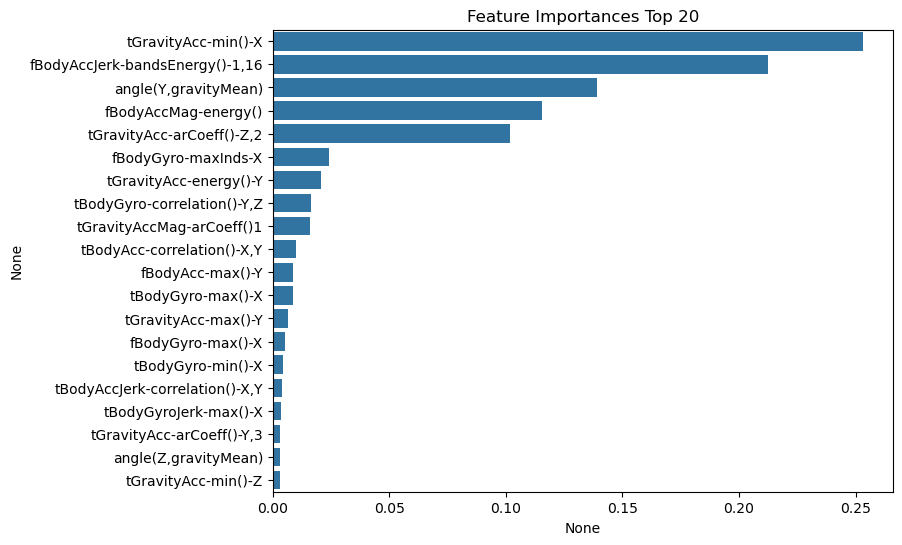

In [21]:
# 피처 중요도 알아보기 => 막대그래프로 표현
import seaborn as sns
ftr_importances_values = best_df_clf.feature_importances_
# Top 중요도로 정렬을 쉽게 하고 Seaborn의 막대 그래프로 쉽게 표현하기 위해 Series 변환
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
# 중요도값 순으로 Series 정렬
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]
plt.figure(figsize=(8,6))
plt.title('Feature Importances Top 20')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()

# Top5 피처들이 매우 중요하게 규칙 생성에 영향을 미치고 있음